In [1]:
%load_ext autoreload
%autoreload 2

# Analysis of hyperparameter search v1

## Imports

In [2]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import jax.numpy as jnp
from jax import random
from flax import linen as nn
from modularRNN.model import CTRNNCell
from modularRNN.task import ModularArithmeticTask
from modularRNN.training import create_train_state, ModelParameters

from sklearn.decomposition import PCA

from functools import partial

2024-04-05 10:12:25.576936: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-05 10:12:26.333739: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-04-05 10:12:26.333800: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-04-05 10:12:26.333806: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed proper

In [3]:
job_folder = "../../data/hyperparameter_1"
search_results = []

for task_id in range(384):
    try:
        metrics_loc = os.path.join(job_folder, f"task_{task_id}/metrics_history.csv")
        metrics_min = pd.read_csv(metrics_loc)['test_loss'].min()

        var_explained_loc = os.path.join(job_folder, f"task_{task_id}/cumulative_variance.npy")
        var_exp_arr = jnp.load(var_explained_loc)
        
        params_loc = os.path.join(job_folder, f"task_{task_id}/params.json")
        with open(params_loc, 'r') as f:
            json_params = json.load(f)
        
        seed = json_params.get('seed', 0)
        alpha = json_params.get('alpha', 0.1)
        noise = json_params.get('noise', 0.05)
        pulse_mean = json_params.get('pulse_mean', 8)
        mod_set = json_params.get('mod_set', [5,])
        mod_value_list = len(mod_set)
        training_trials = json_params.get('training_trials', 3200)
        train_batch_size = json_params.get('train_batch_size', 128)
        testing_trials = json_params.get('testing_trials', 320)
        lr = json_params.get('lr', 0.001)
        epochs = json_params.get('epochs', 500)
        weight_decay = json_params.get('weight_decay', 0.0001)
        l2_penalty = json_params.get('l2_penalty', 0.0001)

        task_stats_params = {
            'test_min': metrics_min,
            'cum_var': var_exp_arr[2].item(),
            'seed': seed,
            'alpha': alpha,
            'noise': noise,
            'pulse_mean': pulse_mean,
            'mod_set': mod_set,
            'mod_value_list': mod_value_list,
            'training_trials': training_trials,
            'train_batch_size': train_batch_size,
            'testing_trials': testing_trials,
            'lr': lr,
            'epochs': epochs,
            'weight_decay': weight_decay,
            'l2_penalty': l2_penalty,
        }
        search_results.append(task_stats_params)

    except FileNotFoundError:
        continue

In [4]:
df_search_results = pd.DataFrame(search_results)
df_search_results.sort_values('cum_var', ascending=False).head(25)

,test_min,cum_var,seed,alpha,noise,pulse_mean,mod_set,mod_value_list,training_trials,train_batch_size,testing_trials,lr,epochs,weight_decay,l2_penalty
207,0.019468,1.000000,207,0.1,0.05,12,[3],1,6400,128,640,0.010,1500,0.0001,0.0001
318,0.000497,0.977951,318,0.1,0.00,12,[3],1,6400,128,640,0.005,2000,0.0001,0.0100
137,0.000492,0.976146,137,0.1,0.00,12,[3],1,6400,128,640,0.005,2000,0.0001,0.0100
193,0.000596,0.967485,193,0.1,0.00,12,[3],1,3200,128,640,0.005,2000,0.0001,0.0100
299,0.079229,0.951334,299,1.0,0.05,12,[8],1,3200,128,640,0.010,2000,0.0001,0.0100
288,0.000571,0.935184,288,0.1,0.00,12,[4],1,6400,128,640,0.010,1500,0.0010,0.0100
149,0.000623,0.932260,149,0.1,0.05,12,[3],1,6400,128,640,0.005,2000,0.0001,0.0100
123,0.000616,0.929837,123,0.1,0.00,12,[4],1,3200,128,640,0.010,2000,0.0001,0.0100
24,0.000638,0.928434,24,0.1,0.05,12,[3],1,6400,128,640,0.005,1500,0.0010,0.0100
104,0.000062,0.927814,104,0.1,0.00,12,[3],1,6400,128,640,0.005,1500,0.0001,0.0010


## Analyze seed 238 performance

In [5]:
task_id = 'task_16'

params_for_json = f"../../data/hyperparameter_1/{task_id}/params.json"
example_csv = f"../../data/hyperparameter_1/{task_id}/metrics_history.csv"
model_params_save = f"../../data/hyperparameter_1/{task_id}/test_params.bin"

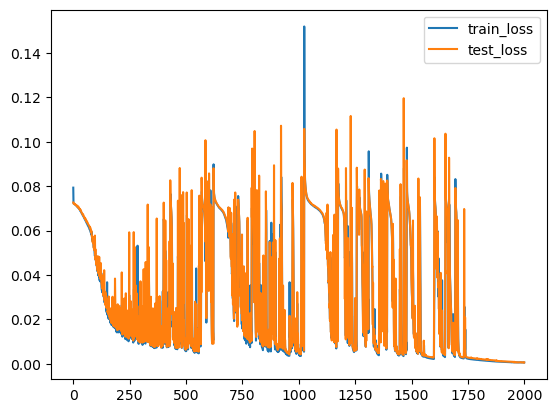

In [6]:
df_metrics = pd.read_csv(example_csv)

plt.plot(df_metrics['train_loss'], label='train_loss')
plt.plot(df_metrics['test_loss'], label='test_loss')
plt.legend()
plt.show()

In [7]:
with open(params_for_json, 'r') as f:
    json_params = json.load(f)

seed = json_params.get('seed', 0)
alpha = json_params.get('alpha', 0.1)
noise = json_params.get('noise', 0.05)
pulse_mean = json_params.get('pulse_mean', 8)
mod_set = json_params.get('mod_set', [5,])
training_trials = json_params.get('training_trials', 3200)
train_batch_size = json_params.get('train_batch_size', 128)
testing_trials = json_params.get('testing_trials', 320)
lr = json_params.get('lr', 0.001)
epochs = json_params.get('epochs', 500)
weight_decay = json_params.get('weight_decay', 0.0001)
l2_penalty = json_params.get('l2_penalty', 0.0001)

key = random.PRNGKey(seed)

In [8]:
mod_set = jnp.array(mod_set)
pulse_distribution = partial(random.poisson, lam=pulse_mean)

key, subkey = random.split(key)
modtask = ModularArithmeticTask(subkey, training_trials, testing_trials, train_batch_size, mod_set, pulse_distribution,)
training_dataset, testing_dataset = modtask.tf_datasets()

100%|██████████| 6400/6400 [00:31<00:00, 206.09it/s]
2024-04-05 10:13:04.467595: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-04-05 10:13:04.467620: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
100%|██████████| 640/640 [00:02<00:00, 299.92it/s]


In [9]:
features = 100
alpha = jnp.float32(alpha)
noise = jnp.float32(noise)

ctrnn = nn.RNN(CTRNNCell(features=features, alpha=alpha, noise=noise, out_shape=10,))

key, subkey = random.split(key)
state = create_train_state(ctrnn, subkey, lr, weight_decay)

In [10]:
model_params = ModelParameters(state)
model_params.deserialize(model_params_save,)

In [11]:
for _inputs, _outputs in testing_dataset.as_numpy_iterator():
    pass
    
key, subkey = random.split(key)
z_0, rates_0 = ctrnn.apply(model_params.params, _inputs, init_key=subkey,)

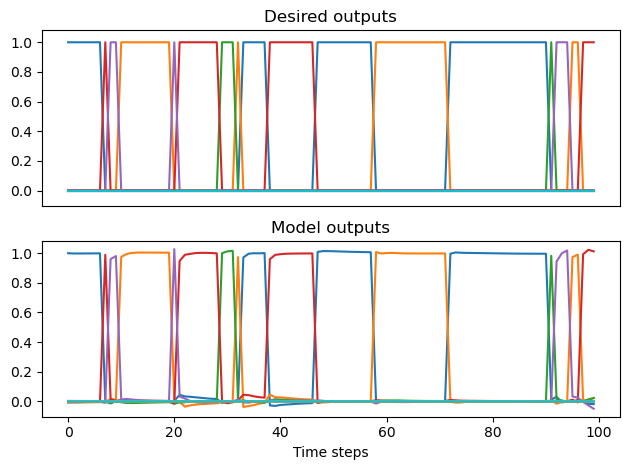

In [12]:
fig, axs = plt.subplots(2, 1, sharey=True)

axs[0].plot(_outputs[0,:,:])
axs[0].set_title('Desired outputs')
axs[0].set_xticks([])
axs[1].plot(z_0[0,:,:])
axs[1].set_title('Model outputs')
axs[1].set_xlabel('Time steps')
plt.tight_layout()
plt.show()

In [13]:
rates_list = []

for _inputs, _outputs in tqdm(training_dataset.as_numpy_iterator()):
    key, subkey = random.split(key)
    _, _rates = ctrnn.apply(model_params.params, _inputs, init_key=subkey,)
    rates_list.append(_rates)

50it [00:18,  2.69it/s]


In [14]:
rates_ = jnp.concatenate(rates_list, axis=0)
rates_shape = rates_.shape
rates_shape

(6400, 100, 100)

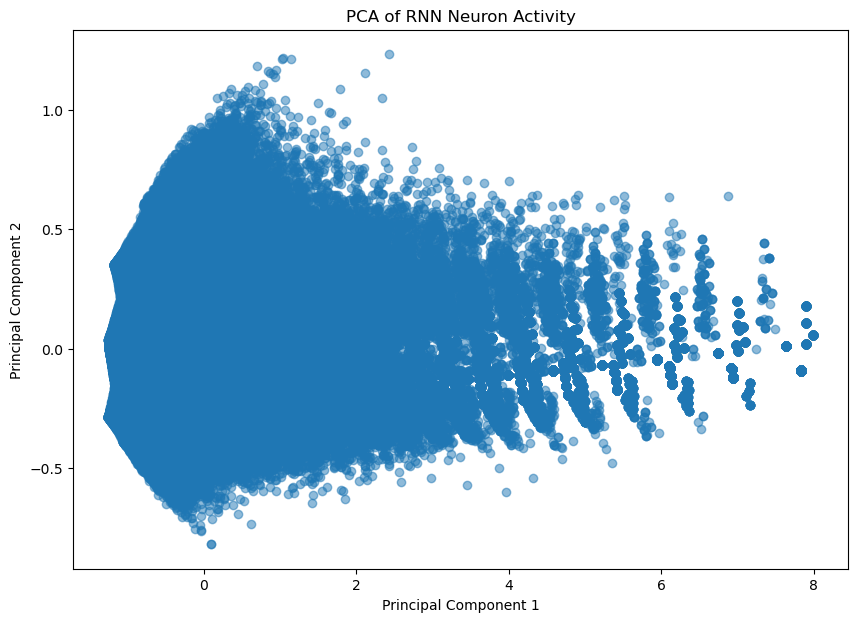

In [15]:
rates_reshaped = rates_.reshape(-1, rates_.shape[-1])

pca = PCA(n_components=2)
principal_components = pca.fit_transform(rates_reshaped)

plt.figure(figsize=(10, 7))
plt.scatter(principal_components[:, 0], principal_components[:, 1], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of RNN Neuron Activity')
plt.show()

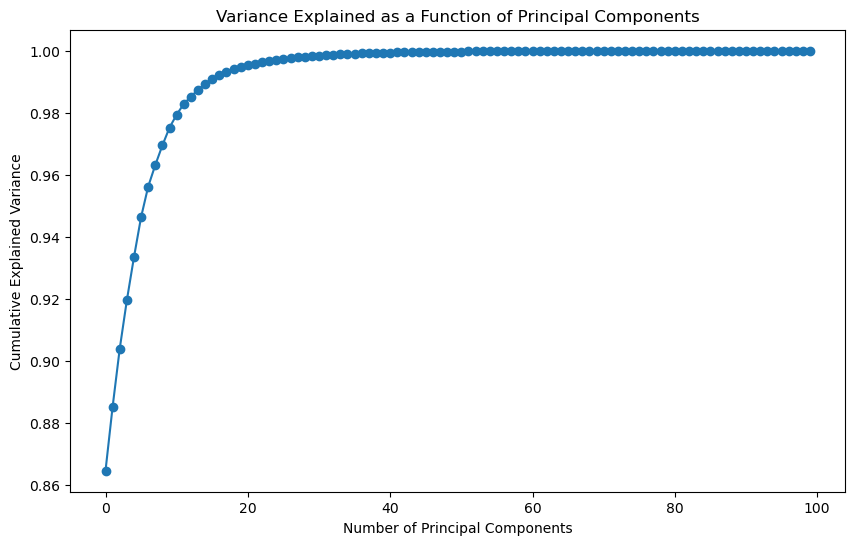

In [16]:
pca_full = PCA()
pca_full.fit(rates_reshaped)

cumulative_variance = jnp.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Variance Explained as a Function of Principal Components')
plt.show()

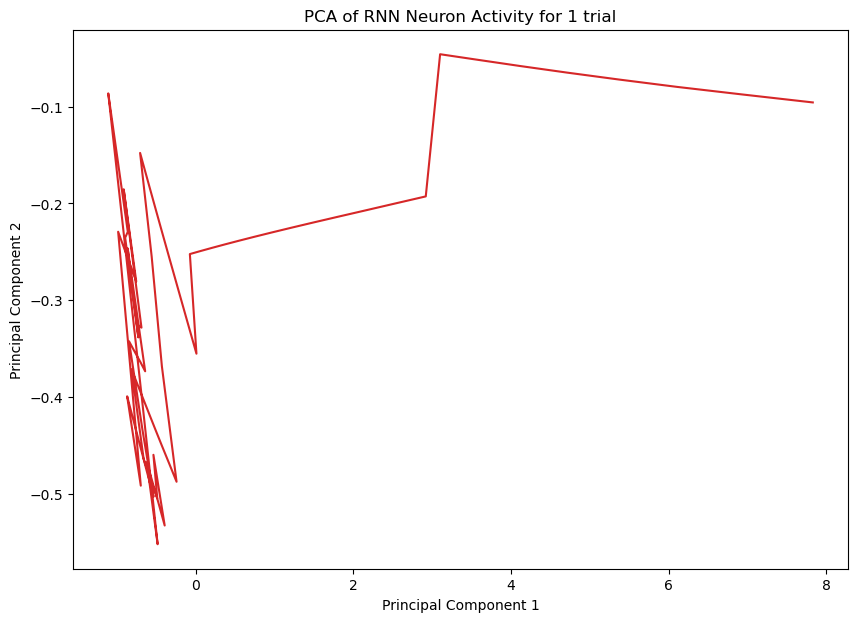

In [17]:
reshaped_pc = principal_components.reshape(rates_shape[0], rates_shape[1], 2)

plt.figure(figsize=(10, 7))
plt.plot(reshaped_pc[0, :, 0], reshaped_pc[0, :, 1], color='tab:red')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of RNN Neuron Activity for 1 trial')
plt.show()